## Objectives


Spark ML Library is also commonly called MLlib and is used to perform machine learning operations using DataFrame-based APIs.

After completing this lab you will be able to:


* Import the Spark ML and Statistics Libraries
* Perform basic statistics operations using Spark
* Build a simple linear regression model using Spark ML
* Train the model and perform evaluation


----


## Setup


In [1]:

import findspark
findspark.init()

In [2]:
# Pandas is a popular data science package for Python. In this lab, we use Pandas to load a CSV file from disc to a pandas dataframe in memory.
import pandas as pd
import matplotlib.pyplot as plt
# pyspark is the Spark API for Python. In this lab, we use pyspark to initialize the spark context. 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

## Exercise 1 -  Spark session


In this exercise, you will create and initialize the Spark session needed to load the dataframes and operate on it


#### Task 1: Creating the spark session and context


In [3]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

23/05/31 12:12:45 WARN Utils: Your hostname, irteza resolves to a loopback address: 127.0.1.1; using 192.168.0.228 instead (on interface wlo1)
23/05/31 12:12:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/31 12:12:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Task 2: Initialize Spark session
To work with dataframes we just need to verify that the spark session instance has been created.
Feel free to click on the "Spark UI" button to explore the Spark UI elements.


In [4]:
spark

#### Task 2: Importing Spark ML libraries

In this exercise we will import 4 SparkML functions. 


1. (Feature library) VectorAssembler(): This function is used to create feature vectors from dataframes/raw data. These feature vectors are required to train a ML model or perform any statistical operations. 
2. (Stat library) Correlation(): This function is from the statistics library within SparkML. This function is used to calculate correlation between feature vectors. 
3. (Feature library) Normalized(): This function is used to normalize features. Normalizing features leads to better ML model convergence and training results. 
4. (Regression Library) LinearRegression(): This function is used to create a Linear Regression model and train it. 


In [5]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

## Exercise 2 - Loading the data and Creating Feature Vectors


In this section, you will first read the CSV file into a pandas dataframe and then read it into a Spark dataframe

Pandas is a library used for data manipulation and analysis. Pandas offers data structures and operations for creating and manipulating Data Series and DataFrame objects. Data can be imported from various data sources, e.g., Numpy arrays, Python dictionaries and CSV files. Pandas allows you to manipulate, organize and display the data. 

In this example we use a dataset that contains information about cars. 


#### Task 1: Loading data into a Pandas DataFrame


In [6]:
# Read the file using `read_csv` function in pandas
cars = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars.csv')

In [7]:
# Preview a few records
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


For this example, we pre process the data and only use 3 columns. This preprocessed dataset can be found in the `cars2.csv` file. 


In [8]:
cars2 = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-BD0225EN-SkillsNetwork/labs/data/cars2.csv', header=None, names=["mpg", "hp", "weight"])
cars2.head()

,mpg,hp,weight
0,18.0,130.0,3504.0
1,15.0,165.0,3693.0
2,18.0,150.0,3436.0
3,16.0,150.0,3433.0
4,17.0,140.0,3449.0


#### Task 2: Loading data into a Spark DataFrame


In [10]:
# We use the `createDataFrame` function to load the data into a spark dataframe

sdf = spark.createDataFrame(cars2)

In [11]:
# Let us look at the schema of the loaded spark dataframe
sdf.printSchema()

root
 |-- mpg: double (nullable = true)
 |-- hp: double (nullable = true)
 |-- weight: double (nullable = true)



#### Task 3: Converting data frame columns into feature vectors

In this task we use the `VectorAssembler()` function to convert the dataframe columns into feature vectors. 
For our example, we use the horsepower ("hp) and weight of the car as input features and the miles-per-gallon ("mpg") as target labels.


In [12]:
assembler = VectorAssembler(
    inputCols=["hp", "weight"],
    outputCol="features")

output = assembler.transform(sdf).select('features','mpg')

We now create a test-train split of 75%-25%


In [14]:
train, test = output.randomSplit([0.75, 0.25])
train.show(5)

+-------------+----+
|     features| mpg|
+-------------+----+
|[46.0,1835.0]|26.0|
|[85.0,2587.0]|21.0|
|[87.0,2672.0]|25.0|
|[88.0,2130.0]|27.0|
|[88.0,3139.0]|18.0|
+-------------+----+
only showing top 5 rows



In [21]:
train.head()

Row(features=DenseVector([46.0, 1835.0]), mpg=26.0)

## Exercise 3 - Basic stats and feature engineering


In this exercise, we determine the correlation between feature vectors and normalize the features.


#### Task 1: Correlation

Spark ML has inbuilt Correlation function as part of the Stat library. We use the correlation function to determine the different types of correlation between the 2 features - "hp" and "weight". 


In [22]:
r1 = Correlation.corr(train, "features").head(10)
print("Pearson correlation matrix:\n" + str(r1[0][0]))

Pearson correlation matrix:
DenseMatrix([[1.        , 0.87999738],
             [0.87999738, 1.        ]])


In [24]:
r2 = Correlation.corr(train, "features", "spearman").head()
print("Spearman correlation matrix:\n" + str(r2[0]))

Spearman correlation matrix:
DenseMatrix([[1.      , 0.888552],
             [0.888552, 1.      ]])


We can see that there is a 0.86 (or 86%) correlation between the features. That is logical as a car with higher horsepower likely has a bigger engine and thus weighs more. We can also visualize the feature vectors to see that they are indeed correlated. 


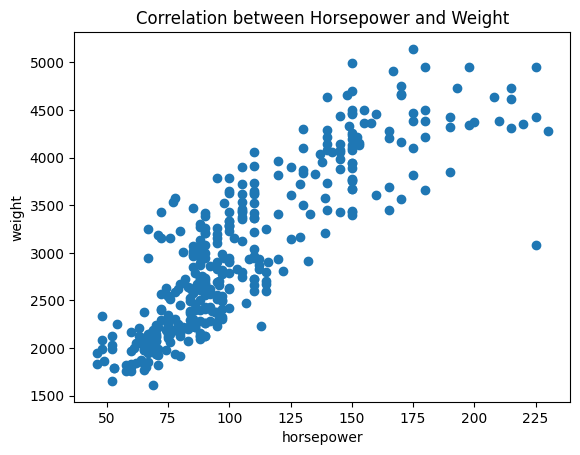

In [23]:
plt.figure()
plt.scatter(cars2["hp"], cars2["weight"])
plt.xlabel("horsepower")
plt.ylabel("weight")
plt.title("Correlation between Horsepower and Weight")
plt.show()

#### Task 2: Normalization

In order for better model training and convergence, it is a good practice to normalize feature vectors. 


In [25]:
normalizer = Normalizer(inputCol="features", outputCol="features_normalized", p=1.0)
train_norm = normalizer.transform(train)
print("Normalized using L^1 norm")
train_norm.show(5, truncate=False)

Normalized using L^1 norm
+-------------+----+-----------------------------------------+
|features     |mpg |features_normalized                      |
+-------------+----+-----------------------------------------+
|[46.0,1835.0]|26.0|[0.024455077086656035,0.9755449229133439]|
|[85.0,2587.0]|21.0|[0.03181137724550898,0.968188622754491]  |
|[87.0,2672.0]|25.0|[0.031533164189923885,0.9684668358100761]|
|[88.0,2130.0]|27.0|[0.03967538322813345,0.9603246167718665] |
|[88.0,3139.0]|18.0|[0.027269910133250697,0.9727300898667492]|
+-------------+----+-----------------------------------------+
only showing top 5 rows



In [26]:
train_norm.show(5, truncate=True)

+-------------+----+--------------------+
|     features| mpg| features_normalized|
+-------------+----+--------------------+
|[46.0,1835.0]|26.0|[0.02445507708665...|
|[85.0,2587.0]|21.0|[0.03181137724550...|
|[87.0,2672.0]|25.0|[0.03153316418992...|
|[88.0,2130.0]|27.0|[0.03967538322813...|
|[88.0,3139.0]|18.0|[0.02726991013325...|
+-------------+----+--------------------+
only showing top 5 rows



#### Task 2: Standard Scaling

This is a standard practice to scale the features such that all columns in the features have zero mean and unit variance.


In [27]:
standard_scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
train_model = standard_scaler.fit(train)
train_scaled = train_model.transform(train)
train_scaled.show(5, truncate=False)

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[46.0,1835.0]|26.0|[1.1969404274087996,2.1396468549887775]|
|[85.0,2587.0]|21.0|[2.2117377462988688,3.016493958504614] |
|[87.0,2672.0]|25.0|[2.263778634447078,3.115605665683931]  |
|[88.0,2130.0]|27.0|[2.289799078521182,2.4836227799052293] |
|[88.0,3139.0]|18.0|[2.289799078521182,3.660137045127941]  |
+-------------+----+---------------------------------------+
only showing top 5 rows



In [28]:
test_scaled = train_model.transform(test)
test_scaled.show(5, truncate=False)

+-------------+----+---------------------------------------+
|features     |mpg |features_scaled                        |
+-------------+----+---------------------------------------+
|[72.0,2408.0]|22.0|[1.8734719733355125,2.807776363385818] |
|[86.0,2220.0]|23.0|[2.2377581903729733,2.5885645875068586]|
|[88.0,2130.0]|27.0|[2.289799078521182,2.4836227799052293] |
|[88.0,3302.0]|19.0|[2.289799078521182,3.8501983188953366] |
|[90.0,2264.0]|28.0|[2.3418399666693905,2.6398694712232107]|
+-------------+----+---------------------------------------+
only showing top 5 rows



## Exercise 4 - Building and Training a Linear Regression Model


In this exercise, we train a Linear Regression model `lrModel` on our training dataset. We train the model on the standard scaled version of features. 
We also print the final RMSE and R-Squared metrics. 


#### Task 1: Create and Train model

We can create the model using the `LinearRegression()` class and train using the `fit()` function. 


In [29]:
# Create a LR model
lr = LinearRegression(featuresCol='features_scaled', labelCol='mpg', maxIter=100)

# Fit the model
lrModel = lr.fit(train_scaled)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
#trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R-squared: %f" % trainingSummary.r2)

23/05/31 12:42:02 WARN Instrumentation: [28c7528b] regParam is zero, which might cause numerical instability and overfitting.
23/05/31 12:42:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Coefficients: [-1.8214254733092672,-5.152120887828171]
Intercept: 46.43430044783703
RMSE: 4.388952
R-squared: 0.705802


We see a RMSE (Root mean squared error) of 4.26. This means that our model predicts the `mpg` with an average error of 4.2 units. 


#### Task 2: Predict on new data

Once a model is trained, we can then `transform()` new unseen data (for eg. the test data) to generate predictions.
In the below cell, notice the "prediction" column that contains the predicted "mpg".


In [30]:
lrModel.transform(test_scaled).show(5)

+-------------+----+--------------------+------------------+
|     features| mpg|     features_scaled|        prediction|
+-------------+----+--------------------+------------------+
|[72.0,2408.0]|22.0|[1.87347197333551...|28.555907621922454|
|[86.0,2220.0]|23.0|[2.23775819037297...| 29.02179299599885|
|[88.0,2130.0]|27.0|[2.28979907852118...|29.467677275622865|
|[88.0,3302.0]|19.0|[2.28979907852118...| 22.42691489639689|
|[90.0,2264.0]|28.0|[2.34183996666939...|28.567886834302666|
+-------------+----+--------------------+------------------+
only showing top 5 rows



### Question 1 - Correlation


Print the correlation matrix for the test dataset split we created above. 


In [32]:
test_corr = Correlation.corr(test,"features").head()
print(test_corr[0])

DenseMatrix([[1.        , 0.82256927],
             [0.82256927, 1.        ]])


### Question 2 - Feature Normalization


Normalize the training features by using the L2 norm of the feature vector.


In [36]:
norm2 = Normalizer(inputCol="features",outputCol="features_norm2",p=2)
train_norm2 = norm2.transform(train)
train_norm2.show(5,truncate=False)

+-------------+----+-----------------------------------------+
|features     |mpg |features_norm2                           |
+-------------+----+-----------------------------------------+
|[46.0,1835.0]|26.0|[0.025060247064771873,0.9996859426925301]|
|[85.0,2587.0]|21.0|[0.032838869734902014,0.9994606588728414]|
|[87.0,2672.0]|25.0|[0.03254263484012658,0.9994703481933128] |
|[88.0,2130.0]|27.0|[0.04127933931642943,0.9991476448181215] |
|[88.0,3139.0]|18.0|[0.028023395840095194,0.9996072675233956]|
+-------------+----+-----------------------------------------+
only showing top 5 rows



### Question 3 - Train Model


Repeat the model training shown above for another 100 iterations and report the coefficients.


In [41]:
linR = LinearRegression(featuresCol="features_scaled",labelCol="mpg",maxIter=100)
linR_model = linR.fit(train_scaled)
print(linR_model.coefficients)
lr_summ = linR_model.summary
print(lr_summ.r2)

23/05/31 13:16:46 WARN Instrumentation: [a76436a6] regParam is zero, which might cause numerical instability and overfitting.


[-1.8214254733092672,-5.152120887828171]
0.7058018791272898


In [43]:
linR_model.transform(test_scaled).show(5,truncate=False)

+-------------+----+---------------------------------------+------------------+
|features     |mpg |features_scaled                        |prediction        |
+-------------+----+---------------------------------------+------------------+
|[72.0,2408.0]|22.0|[1.8734719733355125,2.807776363385818] |28.555907621922454|
|[86.0,2220.0]|23.0|[2.2377581903729733,2.5885645875068586]|29.02179299599885 |
|[88.0,2130.0]|27.0|[2.289799078521182,2.4836227799052293] |29.467677275622865|
|[88.0,3302.0]|19.0|[2.289799078521182,3.8501983188953366] |22.42691489639689 |
|[90.0,2264.0]|28.0|[2.3418399666693905,2.6398694712232107]|28.567886834302666|
+-------------+----+---------------------------------------+------------------+
only showing top 5 rows

